# Calculate watermass transformation
From Groeskamp et al. (2019), equation 4:
$$ G(\lambda) = \frac{\partial}{\partial \lambda}\iiint_{\lambda'\leq\lambda}\rho\dot{\lambda}dV $$

For general vertical coordinate $s$, the conservation equation for tracer $C$ integrated over a layer is given by:
$$\int^{z_{k-1}}_{z_k}\rho \dot{C} dz = \partial_t(\rho C h) + \nabla\cdot (\rho C \mathbf{u} h) + \Delta_k(\rho C w^{(s)}) $$
where $\rho$ is the _in situ_ density, $\rho_l$ is the locally referenced potential density, $\mathbf{u}$ and $w^{(s)}$ are the along-layer and dia-surface residual velocities respectively, $\Delta_k$ is a discrete difference operator in the vertical dimension, and $h$ is the layer thickness.

Noting that $\rho\dot{\rho_l} = \rho_{l,\theta}\rho\dot{\theta} + \rho_{l,S}\rho\dot{S}$, transformation across the locally referenced potential density surface can be written:
$$ \begin{align}
G(\rho_l) &= \frac{\partial}{\partial \rho_l} \iint dA \sum_{\rho_l'\leq \rho_l} \int^{z_{k-1}}_{z_k} \rho \dot{\rho_l'} dz \\
          &= \frac{\partial}{\partial \rho_l} \iint dA \sum_{\rho_l'\leq \rho_l} \big( \rho_{l,\theta}[\partial_t(\rho \theta h) + \nabla\cdot (\rho \theta \mathbf{u} h) + \Delta_k(\rho \theta w^{(s)})] + \rho_{l,S}[\partial_t(\rho S h) + \nabla\cdot (\rho S \mathbf{u} h) + \Delta_k(\rho S w^{(s)})] \big)
\end{align}$$
where we have made the asssumption that $\rho_{l,\theta}$ and $\rho_{l,S}$ are constant within each layer.

In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import budgetcalcs as bc

In [2]:
rootdir = '/archive/gam/ESM4/DECK/ESM4_piControl_D/gfdl.ncrc4-intel16-prod-openmp/history/'
filename = '08500101.ocean_month_rho2.nc'
ds = xr.open_dataset(rootdir+filename)

filename_native = '08500101.ocean_month.nc'
ds_native = xr.open_dataset(rootdir+filename_native)

# Correct MOM6 tendencies to account for mass in cell
# i.e. convert from [mol kg^-1 m s^-1] to [mol m^-2 s^-1]
rho0=1035.0
ds['o2h_tendency'] *= rho0
ds['o2h_tendency_vert_remap'] *= rho0
ds['o2_advection_xy'] *= rho0
ds['o2_dfxy_cont_tendency'] *= rho0
ds['o2_vdiffuse_impl'] *= rho0
# Remove bottom boundary flux from jo2_plus_btm (already included in o2_vdiffuse_impl)
# jo2_btm = xr.zeros_like(ds.jo2_plus_btm)
# jo2_btm.loc[dict(zl=ds.zl.max())]=ds.o2_btf
# jo2 = ds.jo2_plus_btm - jo2_btm
# jo2.name = 'jo2'
# ds = xr.merge([ds,jo2])

/nbhome/gam/miniconda/envs/mom6/lib/python3.7/site-packages/xarray/coding/times.py:419: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  self.use_cftime)


In [3]:
# Calculate material derivative of heat
termsLHS = ['opottemptend','T_advection_xy','Th_tendency_vert_remap']
signsLHS = [-1,1,1]
termsRHS = ['boundary_forcing_heat_tendency','internal_heat_tend_3d','opottempdiff','opottemppmdiff','frazil_heat_tendency']
signsRHS = [1,1,1,1,1]
Dheat, dheat, error_heat = bc.calc_materialderivative(ds,termsLHS,signsLHS,termsRHS,signsRHS,vertc='rho2_l',plot=False)

In [4]:
# Calculate material derivate for salt
termsLHS = ['osalttend','S_advection_xy','Sh_tendency_vert_remap']
signsLHS = [-1,1,1]
termsRHS = ['boundary_forcing_salt_tendency','osaltdiff','osaltpmdiff']
signsRHS = [1,1,1]
Dsalt, dsalt, error_salt = bc.calc_materialderivative(ds,termsLHS,signsLHS,termsRHS,signsRHS,plot=False)

In [5]:
# Calculate material derivative for density
Dheat = -1*Dheat
Dsalt = -1*Dsalt
Drho = -(ds.alpha/ds_native.rhozero)*Dheat/ds_native.C_p+(ds.beta/ds_native.rhozero)*Dsalt
drho = -(ds.alpha/ds_native.rhozero)*dheat/ds_native.C_p+(ds.beta/ds_native.rhozero)*dsalt
rhoDrho = ds.rhopot2*Drho
rhodrho = ds.rhopot2*drho

In [6]:
# Integrate tendencies in each layer
# First, multiply density tendency by grid cell area
area3d = ds_native.areacello*xr.ones_like(ds.temp) # Expand areas to 3D
rhoDrho_cell = rhoDrho*area3d
rhodrho_cell = rhodrho*area3d
# Sum up in each layer
rhoDrho_int = rhoDrho_cell.sum(dim=['xh','yh']).squeeze()
rhodrho_int = rhodrho_cell.sum(dim=['xh','yh']).squeeze()

In [7]:
# Divide by density interval
# (and by Boussinesq reference density to convert to m3s-1)
# (and by 1E6 to convert to Sv)
dr = ds.rho2_i.diff(dim='rho2_i').rename({'rho2_i':'rho2_l'}).assign_coords(rho2_l=ds.rho2_l)
G_D = rhoDrho_int/dr/ds_native.rhozero/1E6
G_d = rhodrho_int/dr/ds_native.rhozero/1E6

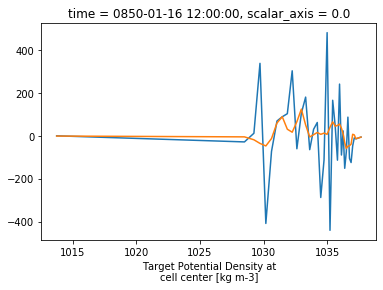

In [8]:
G_D.plot()
G_d.plot()